In [1]:
import sys
print(sys.executable)


C:\Users\tomst\anaconda3\envs\f1\python.exe


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1
import os

In [6]:
sns.set_theme()

In [7]:
os.makedirs("f1_cache", exist_ok=True)
fastf1.Cache.enable_cache("f1_cache")


In [60]:
session = fastf1.get_session(2023, "Monza", "Q")
session.load()

core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '63', '11', '23', '81', '44', '4', '14', '22', '40', '27', '77', '2', '24', '10', '31', '20', '18']


In [61]:
laps = session.laps
lap_ver = laps.pick_driver("VER").pick_fastest()
lap_lec = laps.pick_driver("LEC").pick_fastest()

print("VER fastest lap: ", lap_ver["LapTime"])
print("LEC fastest lap:", lap_lec["LapTime"])

VER fastest lap:  0 days 00:01:20.307000
LEC fastest lap: 0 days 00:01:20.361000


C:\Users\tomst\anaconda3\envs\f1\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\tomst\anaconda3\envs\f1\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


In [62]:
tel1 = lap_ver.get_car_data().add_distance()
tel2 = lap_lec.get_car_data().add_distance()

print("tel1 length:", len(tel1))
print("tel2 length:", len(tel2))
tel1.head()

tel1 length: 294
tel2 length: 296


,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance
0,2023-09-02 14:59:05.502,11270.0,318.0,8,100.0,False,8,car,0 days 00:00:00.232000,0 days 01:14:05.391000,20.493333
1,2023-09-02 14:59:05.862,11283.0,320.0,8,100.0,False,8,car,0 days 00:00:00.592000,0 days 01:14:05.751000,52.493333
2,2023-09-02 14:59:06.182,11298.0,321.0,8,100.0,False,8,car,0 days 00:00:00.912000,0 days 01:14:06.071000,81.026667
3,2023-09-02 14:59:06.502,11422.0,322.0,8,100.0,False,14,car,0 days 00:00:01.232000,0 days 01:14:06.391000,109.648889
4,2023-09-02 14:59:06.822,11440.0,326.0,8,100.0,False,12,car,0 days 00:00:01.552000,0 days 01:14:06.711000,138.626667


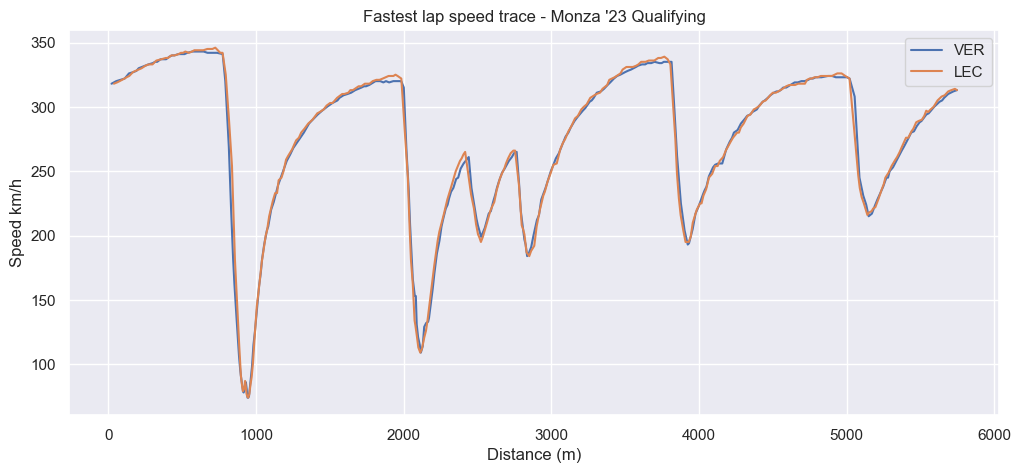

In [63]:
plt.figure(figsize=(12,5))
plt.plot(tel1["Distance"], tel1["Speed"], label = "VER")
plt.plot(tel2["Distance"], tel2["Speed"], label = "LEC")
plt.xlabel("Distance (m)")
plt.ylabel("Speed km/h")
plt.title("Fastest lap speed trace - Monza '23 Qualifying")
plt.grid(True)
plt.legend()
plt.show()

In [64]:
dist_ref = tel1 ["Distance"].values

In [65]:
speed_ver = tel1["Speed"].values

In [66]:
speed_lec_interp = np.interp(
    dist_ref,
    tel2["Distance"].values,
    tel2["Speed"].values
)

In [67]:
delta_df = pd.DataFrame({
    "Distance": dist_ref,
    "Speed_VER": speed_ver,
    "Speed_LEC": speed_lec_interp
})

In [68]:
delta_df["DeltaSpeed"] = delta_df["Speed_VER"] - delta_df["Speed_LEC"]

In [69]:
delta_df.head()

,Distance,Speed_VER,Speed_LEC,DeltaSpeed
0,20.493333,318.0,318.000000,0.000000
1,52.493333,320.0,318.744592,1.255408
2,81.026667,321.0,320.330676,0.669324
3,109.648889,322.0,322.121633,-0.121633
4,138.626667,326.0,323.909352,2.090648


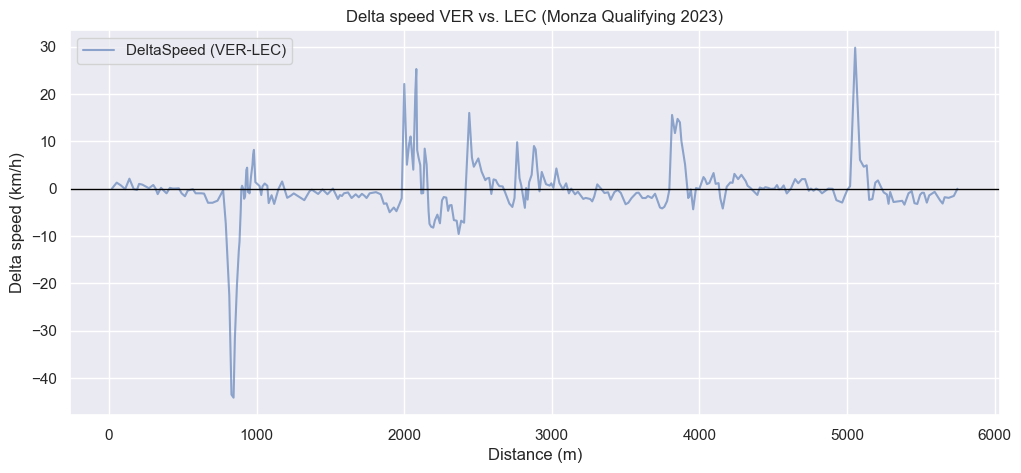

In [70]:
plt.figure(figsize=(12,5))
plt.plot(delta_df["Distance"], delta_df["DeltaSpeed"], label="DeltaSpeed (VER-LEC)", alpha = 0.6)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Distance (m)")
plt.ylabel("Delta speed (km/h)")
plt.title("Delta speed VER vs. LEC (Monza Qualifying 2023)")
plt.grid(True)
plt.legend()
plt.show()

In [71]:
delta_df["DeltaSmooth"] = delta_df["DeltaSpeed"].ewm(span=20, adjust=False).mean()

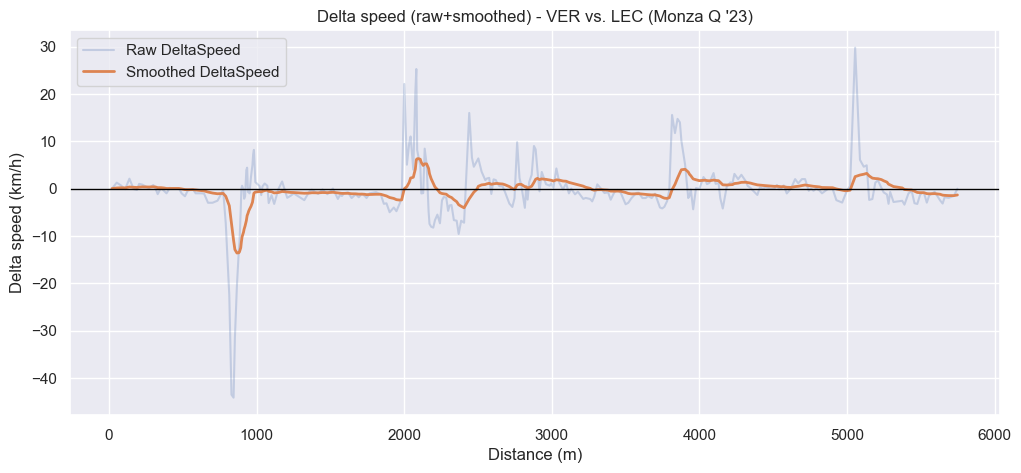

In [72]:
plt.figure(figsize=(12,5))
plt.plot(delta_df["Distance"], delta_df["DeltaSpeed"], label="Raw DeltaSpeed", alpha=0.25)
plt.plot(delta_df["Distance"], delta_df["DeltaSmooth"], label="Smoothed DeltaSpeed", linewidth=2)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Distance (m)")
plt.ylabel("Delta speed (km/h)")
plt.title("Delta speed (raw+smoothed) - VER vs. LEC (Monza Q '23)")
plt.grid(True)
plt.legend()
plt.show()

In [73]:
circuit_info = session.get_circuit_info()
corners = circuit_info.corners
corners[["Number", "Letter", "Distance"]].head(10)

,Number,Letter,Distance
0,1,,881.975520
1,2,,941.391044
2,3,,1460.094440
3,4,,2104.877790
4,5,,2163.966129
5,6,,2527.307783
6,7,,2838.605952
7,8,,3902.570439
8,9,,4014.022435
9,10,,4104.886823


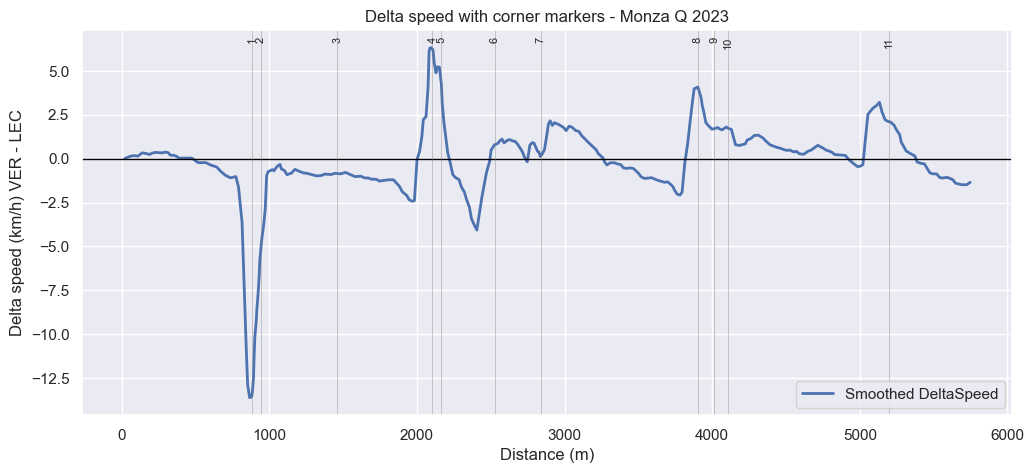

In [79]:
plt.figure(figsize=(12,5))
plt.plot(delta_df["Distance"], delta_df["DeltaSmooth"], label = ["Smoothed DeltaSpeed"], linewidth=2)
plt.axhline(0, color= "black", linewidth=1)

#add corner markers
for _, c in corners.iterrows():
    x = c["Distance"]
    label = str(c["Number"]) + (c["Letter"] if pd.notna(c["Letter"]) else "")
    plt.axvline(x, color="gray", linewidth = 0.7, alpha =0.4)
    plt.text (x, plt.ylim()[1] *0.95, label,rotation=90, va="top", ha="center", fontsize =8)

plt.xlabel("Distance (m)")
plt.ylabel("Delta speed (km/h) VER - LEC")
plt.title("Delta speed with corner markers - Monza Q 2023")
plt.grid(True)
plt.legend()
plt.show()

In [81]:
delta_df["ds"] = delta_df["Distance"].diff()

In [82]:
delta_df["ds"] = delta_df["ds"].fillna(0)

In [84]:
delta_df["v_ver"] = delta_df["Speed_VER"] / 3.6
delta_df["v_lec"] = delta_df["Speed_LEC"] / 3.6

In [85]:
delta_df["dt_ver"] = delta_df["ds"] / delta_df["v_ver"]
delta_df["dt_lec"] = delta_df["ds"] / delta_df["v_lec"]

In [86]:
delta_df["t_ver"] = delta_df["dt_ver"].cumsum()
delta_df["t_lec"] = delta_df["dt_lec"].cumsum()

In [87]:
delta_df["DeltaTime"] = delta_df["t_ver"] - delta_df["t_lec"]

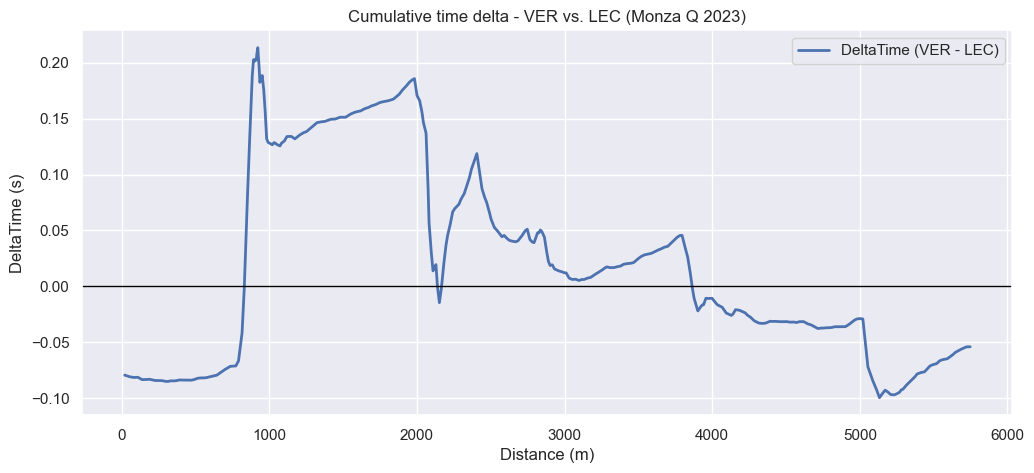

In [92]:
plt.figure(figsize=(12,5))
plt.plot(delta_df["Distance"], delta_df["DeltaTime_corr"], label = "DeltaTime (VER - LEC)", linewidth = 2)
plt.axhline(0, color = "black", linewidth = 1)
plt.xlabel("Distance (m)")
plt.ylabel("DeltaTime (s)")
plt.title("Cumulative time delta - VER vs. LEC (Monza Q 2023)")
plt.grid(True)
plt.legend()
plt.show()

In [89]:
print("DeltaTime at finish (s):", delta_df["DeltaTime"].iloc[-1])
print("LapTime VER (s):", lap_ver["LapTime"].total_seconds())
print("LapTime LEC (s):", lap_lec["LapTime"].total_seconds())
print("Expected (VER-LEC):", lap_ver["LapTime"].total_seconds() - lap_lec["LapTime"].total_seconds())

DeltaTime at finish (s): 0.025305433067018157
LapTime VER (s): 80.307
LapTime LEC (s): 80.361
Expected (VER-LEC): -0.054000000000002046


In [91]:
expected = lap_ver["LapTime"].total_seconds() - lap_lec["LapTime"].total_seconds()
measured = delta_df["DeltaTime"].iloc[-1]

delta_df["DeltaTime_corr"] = delta_df["DeltaTime"] - (measured - expected)

In [ ]:
## Analyse Japan 2025 Qualifying VER - NOR - PIA: